<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/NaturalLanguageProcessing/sentiment_analysis.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/NaturalLanguageProcessing/sentiment_analysis.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Twitter Sentiment Analysis

# 1. Questions

* Can we infer emotion from a tweet text?
* How words are distributed accross the dataset?
* Are words related to one kind of emotion?

# 2. Literature review

[Original Dataset Paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

[Papers with code](https://paperswithcode.com/dataset/imdb-movie-reviews)

---
# 3. Load and explore the dataset

In [1]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

/opt/homebrew/Caskroom/miniforge/base/envs/twitter_nlp/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


You can find the dataset we are going to use in [this website](http://help.sentiment140.com/for-students/).

In [3]:
import requests, zipfile, io
url = 'https://github.com/rgap/NMA-Twitter-SentimentAnalysis/raw/main/data/raw/trainingandtestdata.zip'
raw_data_directory = 'data/raw/'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=raw_data_directory)

In [4]:
# We load the dataset
header_list = ["polarity", "id", "date", "query", "user", "text"]
df = pd.read_csv(raw_data_directory + 'training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)

# Let's have a look at it
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


For this project we will use only the text and the polarity of the tweet. Notice that polarity is 0 for negative tweets and 4 for positive tweet.

In [5]:
X = df.text.values

# Changes values from [0,4] to [0,1]
y = (df.polarity.values > 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

The first thing we have to do before working on the models is to familiarize ourselves with the dataset. This is called Exploratory Data Analisys (EDA).

In [6]:
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

1: @paisleypaisley LOL why do i get ideas so far in advance? it's not even june yet! we need a third knitter to have our own summer group 
0: worst headache ever 
0: @ewaniesciuszko  i am so sad i wont see you! I miss you already. and yeah! that's perfect; i come back the 18th!
1: doesn't know how to spell conked 
0: &quot;So we stand here now and no one knows us at all I won't get used to this I won't get used to being gone&quot;...I miss home and everyone  -a


An interesting thing to analyze is the Word Distribution. In order to count the occurrences of each word, we should tokenize the sentences first.

In [7]:
tokenizer = get_tokenizer("basic_english")

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tokenizer(x_train_text[1]))

Before Tokenize:  worst headache ever 
After Tokenize:  ['worst', 'headache', 'ever']


In [8]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

  0%|          | 0/1280000 [00:00<?, ?it/s]

  0%|          | 0/320000 [00:00<?, ?it/s]

We can count the words occurences and see how many different words are present in our dataset.

In [9]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 669284
['.', 'i', '!', "'", 'to', 'the', ',', 'a', 'my', 'it', 'and', 'you', '?', 'is', 'for', 'in', 's', 'of', 't', 'on', 'that', 'me', 'so', 'have', 'm', 'but', 'just', 'with', 'be', 'at', 'not', 'was', 'this', 'now', 'can', 'good', 'up', 'day', 'all', 'get', 'out', 'like', 'are', 'no', 'go', 'http', '-', 'today', 'do', 'too', 'your', 'work', 'going', 'love', 'we', 'got', 'what', 'lol', 'time', 'back', 'from', 'u', 'one', 'will', 'know', 'about', 'im', 'really', 'don', 'am', 'had', ')', 'see', 'some', 'there', 'its', '&amp', 'how', 'if', 'still', 'they', '&quot', 'night', '(', 'well', 'want', 'new', 'think', '2', 'home', 'thanks', 'll', 'oh', 'when', 'as', 'he', 'more', 'here', 'much', 'off']


Now we can plot their distribution.

In [10]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 0.13970153178620734% most common words account for the 80.00532743602652% of the occurrences


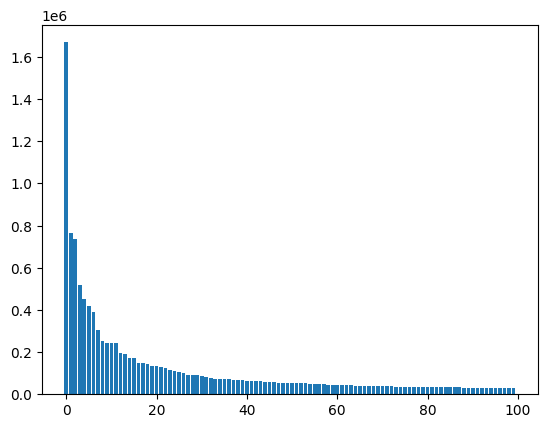

In [11]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

It is very common to find this kind of distribution when analyzing corpus of text. This is referred to as the [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law).

Usually the number of words in the dictionary will be very large. 

Here are some thing we can do to reduce that number:

* Remove puntuation.
* Remove stop-words.
* Steaming.
* Remove very uncommon words (the words that appears in fewer than N occations).
* Nothing: we can use a pretrain model that handles this kind of situations.


We used one of the simplest tokenizers availables. This tokenizer does not take into account many quirks of the language. Moreover, diferent languages have different quirks, so there is no "universal" tokenizers. There are many libraries that have "better" tokenizers:

* [Spacy](https://spacy.io/): it can be accessed using: `get_tokenizer("spacy")`. Spacy supports a wide range of languages.
* [Huggingface](https://huggingface.co/): it has many tokenizers for different laguages. [Doc](https://huggingface.co/transformers/main_classes/tokenizer.html)
* [NLTK](https://www.nltk.org/): it provides several tokenizers. One of them can be accessed using: `get_tokenizer("toktok")`


---
# Step 4: choose toolkit

Our goal is to train a model capable of estimating the sentiment of a tweet (positive or negative) by reading its content. To that end we will try 2 different approaches:

* A logistic regression using sklearn. **NOTE**: it can probaly work better than an SVM model.
* A simple Embedding + RNN.

## Logistic regression

We will represent our senteces using binary vectorization. This means that our data would be represented as a matrix of instances by word with a one if the word is in the instance, and zero otherwise. Sklean vectorizers can also do things such as stop-word removal and puntuation removal, you can read more about in [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [12]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [13]:
print('Before Vectorize: ', x_train_text[3])

Before Vectorize:  doesn't know how to spell conked 


In [14]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 589260)>
  Coords	Values
  (0, 528584)	1
  (0, 165468)	1
  (0, 300381)	1
  (0, 242211)	1
  (0, 489893)	1
  (0, 134160)	1


Now we can train our model. You can check the documentation of this logistic regressor [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression).

In [15]:
model = LogisticRegression(solver='saga')
model.fit(x_train_cv, y_train)

LogisticRegression(solver='saga')

In [16]:
y_pred = model.predict(x_test_cv)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    160000
           1       0.79      0.81      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



## Explainable AI
The best thing about logistic regresion is that it is simple, and we can get some explanations.

In [17]:
print(model.coef_.shape)
print(len(vectorizer.vocabulary_))

words_sk = list(vectorizer.vocabulary_.keys())
words_sk.sort(key=lambda w: model.coef_[0, vectorizer.vocabulary_[w]])

(1, 589260)
589260


In [18]:
for w in words_sk[:20]:
  print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

roni: -3.8625977127123017
inaperfectworld: -3.573439309207433
dontyouhate: -3.5001974329187484
xbllygbsn: -3.4126517021915874
anqju: -3.336434953837981
sad: -3.20052276385081
pakcricket: -3.194904159349193
condolences: -3.132571641791495
heartbreaking: -3.066491697545889
saddest: -3.0420156544550507
sadd: -3.0290862314909974
heartbroken: -3.0287774670135006
boohoo: -3.0226092379659093
sadface: -2.9918269087948715
rachelle_lefevr: -2.9250573739390635
disappointing: -2.902521702804541
lvbu: -2.8947204912713054
saddens: -2.8855055418516273
bummed: -2.8365025968652526
neda: -2.7929637927459545


In [19]:
for w in reversed(words_sk[-20:]):
  print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

iamsoannoyed: 2.849418562659857
myfax: 2.7975535743717175
jennamadison: 2.5667189970142155
yeyy: 2.478046434230527
tryout: 2.4383298813412733
goldymom: 2.43740090297448
wooohooo: 2.4029544497168565
thesupergirl: 2.356512377836073
iammaxathotspot: 2.3116596881411513
londicreations: 2.307446416241598
smilin: 2.2991710760941095
worries: 2.289938773025935
sinfulsignorita: 2.2798963402588064
finchensnail: 2.264330018555255
smackthis: 2.2376644717780074
kv: 2.215832767889474
tojosan: 2.2117969882895427
russmarshalek: 2.2095439877272702
traciknoppe: 2.1768390813081755
congratulations: 2.171589271346398


What does this mean?

Remember the `model.coef_` is the $W$ in:

$$h(x)=\sigma(WX + b)$$

where the label 1 is a positive tweet and the label 0 is a negative tweet.

## Recurrent Neural Network with Pytorch

In the previous section we use a Bag-Of-Words approach to represent each of the tweets. That meas that we only consider how many times each of the words appear in each of the tweets, we didnt take into account the order of the words. But we know that the word order is very important and carries relevant information.

In this section we will solve the same task, but this time we will implement a Recurrent Neural Network (RNN) instead of using a simple Logistic Regression.Unlike feedforward neural networks, RNNs have cyclic connections making them powerful for modeling sequences.

Let's start by importing the relevant libraries.


In [20]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [21]:
# Set the device (check if gpu is available)
device = set_device()

First we will create a Dictionary (`word_to_idx`). This dictionary will map each Token (usually words) to an index (an integer number). We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [22]:
# From previous section, we have a list with the most used tokens
sorted_words[:10]

['.', 'i', '!', "'", 'to', 'the', ',', 'a', 'my', 'it']

Let's select only the most used.

In [23]:
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

In [24]:
# dictionary to go from words to idx
word_to_idx = {}
# dictionary to go from idx to words (just in case)
idx_to_word = {}


# We include the special tokens first
PAD_token = 0
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. These sequences of indexes will be the input to our pytorch model.

In [25]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [26]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)

In [27]:
some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['worst', 'headache', 'ever']
After converting:  [721, 458, 237]


We need all the sequences to have the same length. To select an adequate sequence length, let's explore some statistics about the length of the tweets:

In [28]:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  229
Mean tweet word length:  15.0
99% percent under:  37.0


We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.

In [29]:
 # We choose the max length
 max_length = 40

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
 def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, tweet in enumerate(sentences):
    len_tweet = len(tweet)
    if len_tweet != 0:
      if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
      if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(tweet)[-seq_len:]
  return features

In [30]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [31]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [1, 3, 71, 24, 122, 3, 533, 74, 13, 4, 3, 102, 13, 209, 2, 12, 150, 4, 22, 5, 18, 667, 3, 138, 61, 7, 3296, 4]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    1    3
   71   24  122    3  533   74   13    4    3  102   13  209    2   12
  150    4   22    5   18  667    3  138   61    7 3296    4]


Now, let's convert the data to pytorch format.


In [32]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

Each batch of data in our traning proccess will have the folllowing format:

In [33]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 40])
Sample input: 
 tensor([[   0,    0,    0,  ...,  352,    2,    2],
        [   0,    0,    0,  ..., 1546,    4,    1],
        [   0,    0,    0,  ...,    2, 2317,  696],
        ...,
        [   0,    0,    0,  ...,    6,    7, 1973],
        [   0,    0,    0,  ...,   14,   14,   14],
        [   0,    0,    0,  ...,   17,  290,  161]])
Sample input: 
 tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0])


Now, we will define the `SentimentRNN` class. Most of the model's class will be familiar to you, but there are two important layers we would like you to pay attention to:

*   Embedding Layer
> This layer is like a linear layer, but it makes it posible to use a sequence of inedexes as inputs (instead of a sequence of one-hot-encoded vectors). During training, the Embedding layer learns a linear transformation from the space of words (a vector space of dimension `num_words_dict`) into the a new, smaller, vector space of dimension `embedding_dim`. We suggest you to read this [thread](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/3) and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) if you want to learn more about this particular kind of layers.


*   LSTM layer
> This is one of the most used class of Recurrent Neural Networks. In Pytorch we can add several stacked layers in just one line of code. In our case, the number of layers added are decided with the parameter `no_layers`. If you want to learn more about LSTMs we strongly recommend you this [Colahs thread](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) about them.







In [34]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob

    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True,
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self,x,hidden):
    batch_size = x.size(0)

    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

We choose the parameters of the model.

In [35]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

In [36]:
# Let's define our model
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(30000, 32)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [37]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  1018433


We choose the losses and the optimizer for the training procces.

In [38]:
# loss and optimization functions
lr = 0.001

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

We are ready to train our model.

In [ ]:
# Number of training Epochs
epochs = 1

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()

  for inputs, labels in train_loader:

    # Initialize hidden state
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output,h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()


  # Evaluate on the validation set for this epoch
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}')
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

---
# What's Next?

You can use this project template as a starting point to think about your own project. There are a lot of ways to continue, here we share with you some ideas you migth find useful:

*   **Work on the Preproccesing.** We used a very rudimentary way to tokenize tweets. But there are better ways to preprocess the data. Can you think of a suitable way to preprocess the data for this particular task? How does the performance of the model change when the data is processed correctly?
*   **Work on the Model.** The RNN model proposed in this notebook is not optimized at all. You can work on finding a better architecture or better hyperparamenters. May be using bidirectonal LSTMs or increasing the number of stacked layers can improve the performance, feel free to try different approaches.
*   **Work on the Embedding.** Our model learnt an embedding during the training on this Twitter corpus for a particular task. You can explore the representation of different words in this learned embedding. Also, you can try using different word embeddings. You can train them on this corpus or you can use an embedding trained on another corpus of data. How does the change of the embedding affect the model performance?
*   **Try sentiment analysis on another dataset.** There are lots of available dataset to work with, we can help you find one that is interesting to you. Do you belive that a sentiment analysis model trained on some corpus (Twitter dataset) will perform well on another type of data (for example, youtube comments)?

